# Neural machine translation with attention

## Machine Translation
### Seq2Seq with attention 모델을 활용한 기계 번역
(스페인어를 영어로)

<img src="https://tutorials.pytorch.kr/_images/sphx_glr_seq2seq_translation_tutorial_003.png" alt="attention_plot">

본 예제에서는 데이터를 가져오고, tensor로 변환하는데 tensorflow 예제에 있는 샘플 코드를 사용합니다.

https://tutorials.pytorch.kr/intermediate/seq2seq_translation_tutorial.html

## 모듈 임포트

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from tqdm.auto import tqdm

## 1. 데이터셋 준비

tensorflow 예제 코드에서 데이터를 불러오고, 전처리하는 샘플 코드를 활용합니다.

데이터는 http://www.manythings.org/anki/ 에서 제공하는 언어 데이터 세트를 사용합니다.
이 데이터 세트에서 영어 - 스페인어 데이터세트를 사용합니다.

전처리 단계는 다음과 같습니다.
1. 각 문장에 시작 및 종료 토큰 추가
2. 특수 문자 제거
3. word2idx, idx2word dictionary 생성
4. padding

In [2]:
# Download the file
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

2638744/2638744 [==============================] - 1s 0us/step


In [3]:
path_to_zip

'/root/.keras/datasets/spa-eng.zip'

In [4]:
# unicode file을 ascii로 변환
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [5]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [6]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

    return zip(*word_pairs)

In [7]:
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [8]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
        filters='')
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                          padding='post')

    return tensor, lang_tokenizer

In [9]:
def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs
    targ_lang, inp_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### 더 빠르게 실험 할 수 있도록 데이터 세트 크기 제한 (선택 사항)


100,000 개 이상의 문장으로 구성된 전체 데이터 세트에 대한 훈련은 오랜 시간이 걸립니다. 더 빠르게 학습하기 위해 데이터 세트의 크기를 30,000 개의 문장으로 제한 할 수 있습니다 (물론 더 적은 데이터로 번역 품질이 저하됨).

In [10]:
# Try experimenting with the size of that dataset
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [12]:
input_tensor.shape

(30000, 16)

In [11]:
target_tensor.shape

(30000, 11)

In [16]:
max_length_targ, max_length_inp

(11, 16)

In [17]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


In [18]:
input_tensor_train.shape, target_tensor_train.shape, input_tensor_val.shape, target_tensor_val.shape

((24000, 16), (24000, 11), (6000, 16), (6000, 11))

In [19]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [31]:
input_tensor_train[0]

array([   1,    6,   60,   16,   13, 4312,   14,   13, 8044,    5,    2,
          0,    0,    0,    0,    0], dtype=int32)

In [20]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
6 ----> ¿
60 ----> donde
16 ----> esta
13 ----> la
4312 ----> tapa
14 ----> de
13 ----> la
8044 ----> sarten
5 ----> ?
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
71 ----> where
11 ----> s
13 ----> the
4285 ----> pan
2814 ----> lid
7 ----> ?
2 ----> <end>


In [21]:
# 토큰 수
len(inp_lang.index_word)

9413

In [28]:
# 1 = <start>
# 2 = <end>
inp_lang.index_word[1]

'<start>'

## Pytorch Dataset, DataLoader 변환

In [33]:
input_tensor_train[0]

array([   1,    6,   60,   16,   13, 4312,   14,   13, 8044,    5,    2,
          0,    0,    0,    0,    0], dtype=int32)

In [29]:
vocab_inp_size = len(inp_lang.word_index)+1 # PAD
vocab_tar_size = len(targ_lang.word_index)+1 # PAD

In [34]:
vocab_inp_size

9414

In [30]:
# 데이터셋 만들기
class TextDataset(Dataset):
    def __init__(self, input_datas, target_datas):
        self.input_ids = torch.tensor(input_datas, dtype=torch.long)
        self.target_ids = torch.tensor(target_datas, dtype=torch.long)

    def __getitem__(self, index):
        return self.input_ids[index], self.target_ids[index]

    def __len__(self):
        return len(self.input_ids)

train_dataset = TextDataset(input_tensor_train, target_tensor_train)
valid_dataset = TextDataset(input_tensor_val, target_tensor_val)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64)

## 인코더 및 디코더 모델 생성

Seq2Seq과 달라진 점은 Attention Model이 추가 된 것과 Decoder에서 이 Attention을 활용한다는 것입니다.




TensorFlow [Neural Machine Translation (seq2seq) tutorial](https://github.com/tensorflow/nmt).  에서 읽을 수있는주의를 기울여 인코더-디코더 모델을 구현합니다. 이 예에서는 최신 API 세트를 사용합니다. 이 노트북은 seq2seq 튜토리얼의 [attention equations](https://github.com/tensorflow/nmt#background-on-the-attention-mechanism) 을 구현합니다. 다음 다이어그램은 각 입력 단어에주의 메커니즘에 의해 가중치가 할당 된 다음 디코더가 문장의 다음 단어를 예측하는 데 사용하는 것을 보여줍니다. 아래 그림과 공식은 [Luong's paper](https://arxiv.org/abs/1508.04025v5) 에서 나온주의 메커니즘의 예입니다.

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

입력은 모양의 인코더 출력 (batch_size, max_length, hidden_size) 과 모양의 인코더 숨김 상태 (batch_size, hidden_size) 를 제공하는 인코더 모델을 통해 입력됩니다.

구현되는 방정식은 다음과 같습니다.:

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

이 자습서에서는 인코더에 [Bahdanau attention](https://arxiv.org/pdf/1409.0473.pdf) 를 사용합니다. 단순화 된 형식을 작성하기 전에 표기법을 결정합시다.:

* FC = 완전 연결 (밀집) 계층
* EO = 엔코더 출력
* H = 숨겨진 상태
* X = 디코더에 대한 입력

And the pseudo-code:

* `score = FC(tanh(FC(EO) + FC(H)))`
* `attention weights = softmax(score, axis = 1)`. 기본적으로 Softmax는 마지막 축에 적용되지만 여기서는 점수의 모양이 (batch_size, max_length, hidden_size) 이므로 첫 번째 축 에 적용하려고합니다.  `Max_length` 는 입력의 길이입니다. 각 입력에 가중치를 할당하려고하므로 해당 축에 소프트 맥스를 적용해야합니다.
* `context vector = sum(attention weights * EO, axis = 1)`. 축을 1로 선택한 위와 같은 이유입니다.
* `embedding output` = 디코더 X에 대한 입력은 임베딩 레이어를 통해 전달됩니다.
* `merged vector = concat(embedding output, context vector)`
* 이 병합 된 벡터는 GRU에 제공됩니다.

각 단계의 모든 벡터 모양은 코드의 주석에 지정되어 있습니다.:

In [35]:
hidden_size = 128
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size=128, dropout_p=0.1):
        super(EncoderRNN, self).__init__()

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden # output -> attention 계산 시 사용

encoder = EncoderRNN(vocab_inp_size)

In [36]:
# 어텐션 클래스 생성
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size=128):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

# Decoder with Attention
SOS_token = 1
MAX_LENGTH = max_length_targ
output_size = vocab_tar_size
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size=128, output_size=output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

decoder = AttnDecoderRNN()

## Optimizer, Loss Function




In [37]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
encoder.to(device)
decoder.to(device)

learning_rate = 1e-3

encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss().cuda()

## Training

1. 인코더 출력 과 인코더 숨김 상태 를 반환하는 인코더 를 통해 입력을 전달합니다.
2. 인코더 출력, 인코더 숨김 상태 및 디코더 입력 ( 시작 토큰 )
3. 이 디코더로 전달됩니다.
4. 디코더는 예측 과 디코더 숨김 상태를 반환합니다.
그런 다음 디코더 숨김 상태가 모델로 다시 전달되고 예측이 손실을 계산하는 데 사용됩니다.
5. 디코더에 대한 다음 입력을 결정하기 위해 교사 강제 를 사용합니다.
6. 교사 강제 는 대상 단어 가 디코더의 다음 입력 으로 전달되는 기술입니다.
7. 마지막 단계는 그래디언트를 계산하고이를 옵티 마이저에 적용하고 역 전파하는 것입니다.

In [38]:
epochs = 10

history = {
    'loss': [],
    'val_loss': [],
    'val_acc': []
}

for epoch in range(1, epochs+1):
    # 학습
    encoder.train()
    decoder.train()
    train_loss = []
    for batch_idx, (input_tensor, target_tensor) in enumerate(tqdm(iter(train_loader))):
        input_tensor, target_tensor = input_tensor.to(device), target_tensor.to(device)

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        train_loss.append(loss.item())

    _train_loss = np.mean(train_loss)
    history['loss'].append(_train_loss)

    if epoch % 1 == 0:
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}]')


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [1], Train Loss : [2.33873]


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [2], Train Loss : [1.66925]


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [3], Train Loss : [1.37085]


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [4], Train Loss : [1.16228]


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [5], Train Loss : [1.01506]


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.89523]


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.79414]


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.70630]


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.62860]


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.56304]


## Translate

* 평가 기능은 여기서 교사 강제력을 사용하지 않는다는 점을 제외하면 훈련 루프와 유사합니다.
* 각 시간 단계에서 디코더에 대한 입력은 숨겨진 상태 및 인코더 출력과 함께 이전 예측입니다.
* 그리고 모든 시간 단계에 대한주의 가중치를 저장합니다.

Note: The encoder output is calculated only once for one input.

In [39]:
input_idx2word = inp_lang.index_word
input_word2idx = inp_lang.word_index

target_idx2word = targ_lang.index_word
target_word2idx = targ_lang.word_index

In [59]:
input_tensor, target_tensor = valid_dataset[150]
input_tensor, target_tensor = input_tensor.to(device), target_tensor.to(device)

In [60]:
# 입력값
for idx in input_tensor:
    value = idx.item()
    if not value: break
    print(input_idx2word[value], end=' ')

<start> dejame verlo . <end> 

In [61]:
# 정답값
for idx in target_tensor:
    value = idx.item()
    if not value: break
    print(target_idx2word[value], end=' ')

<start> let me see it . <end> 

In [62]:
# 예측
encoder.eval()
decoder.eval()
EOS_token = 2
with torch.no_grad():
    encoder_outputs, encoder_hidden = encoder(input_tensor.unsqueeze(0))
    # target tensor 제외
    decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

    loss = criterion(
        decoder_outputs.view(-1, decoder_outputs.size(-1)),
        target_tensor.view(-1)
    )
    print(loss)
    # val_loss.append(loss.item())

    _, topi = decoder_outputs.topk(1)
    decoded_ids = topi.squeeze()

    decoded_words = []
    for idx in decoded_ids:
        if idx.item() == EOS_token:
            decoded_words.append('<end>')
            break
        decoded_words.append(target_idx2word[idx.item()])

tensor(0.2376, device='cuda:0')


In [63]:
# 예측값
print(' '.join(decoded_words))

<start> let me see it . <end>


In [64]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy()[0, :len(output_words), :len(input_sentence.split(' '))], cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' '), rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

<ipython-input-64-d76f01272401>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' '), rotation=90)
<ipython-input-64-d76f01272401>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


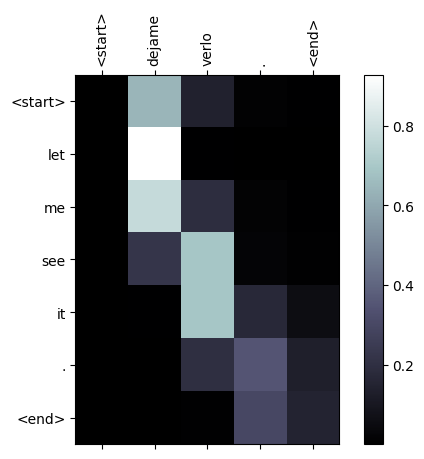

In [65]:
input_sentence = ' '.join([input_idx2word[idx.item()] for idx in input_tensor if idx.item()])

showAttention(input_sentence, decoded_words, decoder_attn)